In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from progressbar import ProgressBar
import cv2
import os
import json

In [3]:
import torch
torch.cuda.device(0)
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [4]:
# create a folder for the mask images
if  not os.path.isdir('../labels'):
    os.makedirs('../labels')

In [5]:
os.listdir('../input')

['train.csv',
 'train',
 'label_descriptions.json',
 'test',
 'sample_submission.csv']

In [6]:
path = Path("../input")
path_img = path/'train'
path_lbl = Path("../labels")

category_num = 27 + 1
size = 224

with open(path/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]
print(label_names)

df = pd.read_csv(path/'train.csv')

['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']


In [8]:
fnames = get_image_files(path_img)
print(fnames[0])

../input/train/6874190f272a1ce960cc2a2c9e0f8c62.jpg


In [9]:
def make_mask_img(segment_df):
    seg_width = segment_df.at[0, "Width"]
    seg_height = segment_df.at[0, "Height"]
    seg_img = np.full(seg_width*seg_height, category_num-1, dtype=np.int32)
    for encoded_pixels, class_id in zip(segment_df["EncodedPixels"].values, segment_df["ClassId"].values):
        pixel_list = list(map(int, encoded_pixels.split(" ")))
        for i in range(0, len(pixel_list), 2):
            start_index = pixel_list[i] - 1
            index_len = pixel_list[i+1] - 1
            if int(class_id.split("_")[0]) < category_num - 1:
                seg_img[start_index:start_index+index_len] = int(class_id.split("_")[0])
    seg_img = seg_img.reshape((seg_height, seg_width), order='F')
    return seg_img

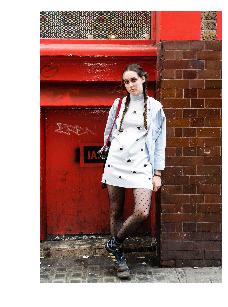

In [10]:
img_file = fnames[500]
img = open_image(img_file)
img.show(figsize=(5,5))

,index,ImageId,EncodedPixels,Height,Width,ClassId
0,21467,1092ef3bd60a4e2e803707855881382f.jpg,1762145 3 1764194 7 1764233 37 1766242 12 1766...,2048,1367,32
1,21468,1092ef3bd60a4e2e803707855881382f.jpg,1752192 20 1754205 60 1756228 90 1758261 110 1...,2048,1367,31
2,21469,1092ef3bd60a4e2e803707855881382f.jpg,975823 22 977869 27 979915 33 981947 52 982006...,2048,1367,31
3,21470,1092ef3bd60a4e2e803707855881382f.jpg,975823 22 977869 27 979915 33 981947 52 982006...,2048,1367,4_0_14_20_41_60_61_91
4,21471,1092ef3bd60a4e2e803707855881382f.jpg,935172 2 937217 6 939262 9 941307 12 943352 16...,2048,1367,10_3_14_20_34_49_67_91
5,21472,1092ef3bd60a4e2e803707855881382f.jpg,1380996 6 1383038 19 1385079 30 1387121 37 138...,2048,1367,33
6,21473,1092ef3bd60a4e2e803707855881382f.jpg,1181329 3 1183376 7 1185422 12 1187468 18 1189...,2048,1367,21
7,21474,1092ef3bd60a4e2e803707855881382f.jpg,1019162 3 1021210 8 1023258 14 1025306 19 1027...,2048,1367,21
8,21475,1092ef3bd60a4e2e803707855881382f.jpg,1054432 5 1056475 13 1058518 22 1060562 29 106...,2048,1367,22
9,21476,1092ef3bd60a4e2e803707855881382f.jpg,1212153 7 1214201 8 1216249 9 1218297 9 122034...,2048,1367,22


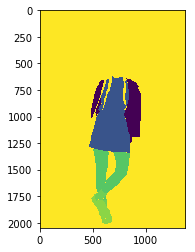

In [11]:
img_name = os.path.basename(img_file)
img_df = df[df.ImageId == img_name].reset_index()
img_mask = make_mask_img(img_df)
plt.imshow(img_mask)
img_df

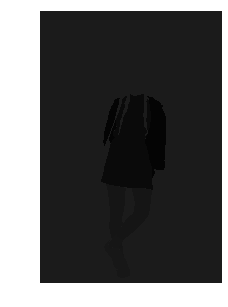

In [12]:
img_mask_3_chn = np.dstack((img_mask, img_mask, img_mask))
cv2.imwrite('../labels/' + os.path.splitext(img_name)[0] + '_P.png', img_mask_3_chn)
png = open_image('../labels/' + os.path.splitext(img_name)[0] + '_P.png')
png.show(figsize=(5,5))

tensor([[[27, 27, 27,  ..., 27, 27, 27],
         [27, 27, 27,  ..., 27, 27, 27],
         [27, 27, 27,  ..., 27, 27, 27],
         ...,
         [27, 27, 27,  ..., 27, 27, 27],
         [27, 27, 27,  ..., 27, 27, 27],
         [27, 27, 27,  ..., 27, 27, 27]]])


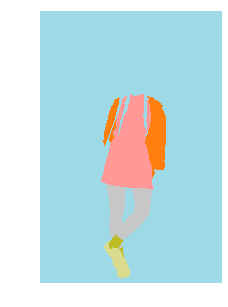

In [13]:
mask = open_mask('../labels/' + os.path.splitext(img_name)[0] + '_P.png')
mask.show(figsize=(5,5), alpha=1)
print(mask.data)

In [14]:
images = df.ImageId.unique()[:5000]

In [15]:
pbar = ProgressBar()

for img in pbar(images):
    img_df = df[df.ImageId == img].reset_index()
    img_mask = make_mask_img(img_df)
    img_mask_3_chn = np.dstack((img_mask, img_mask, img_mask))
    cv2.imwrite('../labels/' + os.path.splitext(img)[0] + '_P.png', img_mask_3_chn)

N/A% (0 of 5000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--
  0% (1 of 5000) |                       | Elapsed Time: 0:00:01 ETA:   1:40:52
  0% (2 of 5000) |                       | Elapsed Time: 0:00:01 ETA:   1:04:30
  0% (3 of 5000) |                       | Elapsed Time: 0:00:01 ETA:   0:52:25
  0% (5 of 5000) |                       | Elapsed Time: 0:00:02 ETA:   0:33:23
  0% (7 of 5000) |                       | Elapsed Time: 0:00:02 ETA:   0:25:22
  0% (8 of 5000) |                       | Elapsed Time: 0:00:02 ETA:   0:23:24
  0% (9 of 5000) |                       | Elapsed Time: 0:00:03 ETA:   0:27:08
  0% (11 of 5000) |                      | Elapsed Time: 0:00:04 ETA:   0:41:45
  0% (13 of 5000) |                      | Elapsed Time: 0:00:04 ETA:   0:34:24
  0% (14 of 5000) |                      | Elapsed Time: 0:00:04 ETA:   0:33:26
  0% (16 of 5000) |                      | Elapsed Time: 0:00:04 ETA:   0:26:36
  0% (17 of 5000) |                     

  3% (151 of 5000) |                     | Elapsed Time: 0:00:52 ETA:   0:36:51
  3% (153 of 5000) |                     | Elapsed Time: 0:00:52 ETA:   0:28:03
  3% (155 of 5000) |                     | Elapsed Time: 0:00:52 ETA:   0:24:15
  3% (157 of 5000) |                     | Elapsed Time: 0:00:53 ETA:   0:23:10
  3% (158 of 5000) |                     | Elapsed Time: 0:00:54 ETA:   0:54:08
  3% (159 of 5000) |                     | Elapsed Time: 0:00:55 ETA:   1:28:02
  3% (160 of 5000) |                     | Elapsed Time: 0:00:55 ETA:   1:01:36
  3% (161 of 5000) |                     | Elapsed Time: 0:00:57 ETA:   1:13:41
  3% (163 of 5000) |                     | Elapsed Time: 0:00:57 ETA:   0:47:58
  3% (165 of 5000) |                     | Elapsed Time: 0:00:57 ETA:   0:36:31
  3% (166 of 5000) |                     | Elapsed Time: 0:00:57 ETA:   0:23:34
  3% (167 of 5000) |                     | Elapsed Time: 0:00:58 ETA:   0:26:19
  3% (168 of 5000) |                    

  5% (296 of 5000) |#                    | Elapsed Time: 0:01:46 ETA:   0:25:56
  5% (297 of 5000) |#                    | Elapsed Time: 0:01:46 ETA:   0:24:05
  5% (299 of 5000) |#                    | Elapsed Time: 0:01:47 ETA:   0:20:31
  6% (301 of 5000) |#                    | Elapsed Time: 0:01:47 ETA:   0:18:28
  6% (303 of 5000) |#                    | Elapsed Time: 0:01:47 ETA:   0:11:22
  6% (305 of 5000) |#                    | Elapsed Time: 0:01:47 ETA:   0:11:14
  6% (307 of 5000) |#                    | Elapsed Time: 0:01:47 ETA:   0:11:13
  6% (308 of 5000) |#                    | Elapsed Time: 0:01:47 ETA:   0:11:14
  6% (310 of 5000) |#                    | Elapsed Time: 0:01:47 ETA:   0:10:45
  6% (311 of 5000) |#                    | Elapsed Time: 0:01:48 ETA:   0:10:44
  6% (312 of 5000) |#                    | Elapsed Time: 0:01:48 ETA:   0:10:59
  6% (314 of 5000) |#                    | Elapsed Time: 0:01:48 ETA:   0:10:20
  6% (316 of 5000) |#                   

  8% (438 of 5000) |#                    | Elapsed Time: 0:02:30 ETA:   0:29:50
  8% (440 of 5000) |#                    | Elapsed Time: 0:02:30 ETA:   0:23:50
  8% (442 of 5000) |#                    | Elapsed Time: 0:02:31 ETA:   0:18:03
  8% (444 of 5000) |#                    | Elapsed Time: 0:02:31 ETA:   0:15:49
  8% (445 of 5000) |#                    | Elapsed Time: 0:02:32 ETA:   0:19:09
  8% (446 of 5000) |#                    | Elapsed Time: 0:02:33 ETA:   1:22:37
  8% (448 of 5000) |#                    | Elapsed Time: 0:02:34 ETA:   0:48:57
  8% (449 of 5000) |#                    | Elapsed Time: 0:02:34 ETA:   0:40:43
  9% (450 of 5000) |#                    | Elapsed Time: 0:02:34 ETA:   0:35:01
  9% (451 of 5000) |#                    | Elapsed Time: 0:02:35 ETA:   0:35:35
  9% (452 of 5000) |#                    | Elapsed Time: 0:02:35 ETA:   0:27:49
  9% (453 of 5000) |#                    | Elapsed Time: 0:02:36 ETA:   0:36:34
  9% (455 of 5000) |#                   

 11% (586 of 5000) |##                   | Elapsed Time: 0:03:23 ETA:   0:14:56
 11% (588 of 5000) |##                   | Elapsed Time: 0:03:23 ETA:   0:13:30
 11% (589 of 5000) |##                   | Elapsed Time: 0:03:23 ETA:   0:12:16
 11% (591 of 5000) |##                   | Elapsed Time: 0:03:23 ETA:   0:11:22
 11% (592 of 5000) |##                   | Elapsed Time: 0:03:23 ETA:   0:11:23
 11% (593 of 5000) |##                   | Elapsed Time: 0:03:24 ETA:   0:11:27
 11% (595 of 5000) |##                   | Elapsed Time: 0:03:25 ETA:   0:20:58
 11% (596 of 5000) |##                   | Elapsed Time: 0:03:26 ETA:   0:50:03
 11% (597 of 5000) |##                   | Elapsed Time: 0:03:27 ETA:   0:54:30
 11% (598 of 5000) |##                   | Elapsed Time: 0:03:27 ETA:   0:52:03
 12% (600 of 5000) |##                   | Elapsed Time: 0:03:28 ETA:   0:37:10
 12% (602 of 5000) |##                   | Elapsed Time: 0:03:28 ETA:   0:25:38
 12% (603 of 5000) |##                  

 14% (737 of 5000) |###                  | Elapsed Time: 0:04:21 ETA:   0:23:42
 14% (739 of 5000) |###                  | Elapsed Time: 0:04:22 ETA:   0:16:38
 14% (741 of 5000) |###                  | Elapsed Time: 0:04:23 ETA:   0:20:45
 14% (742 of 5000) |###                  | Elapsed Time: 0:04:23 ETA:   0:25:35
 14% (743 of 5000) |###                  | Elapsed Time: 0:04:23 ETA:   0:23:06
 14% (745 of 5000) |###                  | Elapsed Time: 0:04:24 ETA:   0:18:23
 14% (747 of 5000) |###                  | Elapsed Time: 0:04:26 ETA:   1:41:29
 14% (749 of 5000) |###                  | Elapsed Time: 0:04:27 ETA:   0:54:03
 15% (751 of 5000) |###                  | Elapsed Time: 0:04:27 ETA:   0:44:30
 15% (752 of 5000) |###                  | Elapsed Time: 0:04:28 ETA:   0:45:59
 15% (753 of 5000) |###                  | Elapsed Time: 0:04:28 ETA:   0:41:11
 15% (754 of 5000) |###                  | Elapsed Time: 0:04:28 ETA:   0:37:55
 15% (755 of 5000) |###                 

 17% (883 of 5000) |###                  | Elapsed Time: 0:05:23 ETA:   0:23:28
 17% (884 of 5000) |###                  | Elapsed Time: 0:05:23 ETA:   0:23:19
 17% (886 of 5000) |###                  | Elapsed Time: 0:05:24 ETA:   0:19:44
 17% (887 of 5000) |###                  | Elapsed Time: 0:05:24 ETA:   0:19:43
 17% (889 of 5000) |###                  | Elapsed Time: 0:05:24 ETA:   0:13:45
 17% (890 of 5000) |###                  | Elapsed Time: 0:05:24 ETA:   0:13:16
 17% (891 of 5000) |###                  | Elapsed Time: 0:05:25 ETA:   0:17:40
 17% (892 of 5000) |###                  | Elapsed Time: 0:05:26 ETA:   0:17:58
 17% (894 of 5000) |###                  | Elapsed Time: 0:05:26 ETA:   0:18:04
 17% (896 of 5000) |###                  | Elapsed Time: 0:05:26 ETA:   0:24:56
 17% (897 of 5000) |###                  | Elapsed Time: 0:05:26 ETA:   0:22:21
 17% (899 of 5000) |###                  | Elapsed Time: 0:05:26 ETA:   0:18:19
 18% (901 of 5000) |###                 

 20% (1035 of 5000) |####                | Elapsed Time: 0:06:17 ETA:   0:11:18
 20% (1037 of 5000) |####                | Elapsed Time: 0:06:17 ETA:   0:10:28
 20% (1038 of 5000) |####                | Elapsed Time: 0:06:17 ETA:   0:08:36
 20% (1040 of 5000) |####                | Elapsed Time: 0:06:17 ETA:   0:08:08
 20% (1041 of 5000) |####                | Elapsed Time: 0:06:18 ETA:   0:08:44
 20% (1042 of 5000) |####                | Elapsed Time: 0:06:18 ETA:   0:13:02
 20% (1043 of 5000) |####                | Elapsed Time: 0:06:19 ETA:   0:13:58
 20% (1045 of 5000) |####                | Elapsed Time: 0:06:19 ETA:   0:12:29
 20% (1047 of 5000) |####                | Elapsed Time: 0:06:19 ETA:   0:11:29
 20% (1049 of 5000) |####                | Elapsed Time: 0:06:19 ETA:   0:09:50
 21% (1051 of 5000) |####                | Elapsed Time: 0:06:19 ETA:   0:09:48
 21% (1053 of 5000) |####                | Elapsed Time: 0:06:19 ETA:   0:08:59
 21% (1054 of 5000) |####               

 23% (1185 of 5000) |####                | Elapsed Time: 0:07:04 ETA:   0:13:35
 23% (1186 of 5000) |####                | Elapsed Time: 0:07:05 ETA:   0:09:17
 23% (1187 of 5000) |####                | Elapsed Time: 0:07:05 ETA:   0:09:16
 23% (1189 of 5000) |####                | Elapsed Time: 0:07:06 ETA:   0:13:04
 23% (1190 of 5000) |####                | Elapsed Time: 0:07:06 ETA:   0:14:45
 23% (1191 of 5000) |####                | Elapsed Time: 0:07:06 ETA:   0:22:11
 23% (1192 of 5000) |####                | Elapsed Time: 0:07:06 ETA:   0:20:56
 23% (1194 of 5000) |####                | Elapsed Time: 0:07:06 ETA:   0:17:25
 23% (1196 of 5000) |####                | Elapsed Time: 0:07:07 ETA:   0:12:41
 23% (1198 of 5000) |####                | Elapsed Time: 0:07:07 ETA:   0:11:36
 24% (1200 of 5000) |####                | Elapsed Time: 0:07:07 ETA:   0:10:51
 24% (1201 of 5000) |####                | Elapsed Time: 0:07:08 ETA:   0:14:36
 24% (1202 of 5000) |####               

 26% (1328 of 5000) |#####               | Elapsed Time: 0:07:52 ETA:   0:27:45
 26% (1329 of 5000) |#####               | Elapsed Time: 0:07:52 ETA:   0:26:44
 26% (1330 of 5000) |#####               | Elapsed Time: 0:07:52 ETA:   0:26:44
 26% (1332 of 5000) |#####               | Elapsed Time: 0:07:52 ETA:   0:19:29
 26% (1333 of 5000) |#####               | Elapsed Time: 0:07:53 ETA:   0:18:42
 26% (1334 of 5000) |#####               | Elapsed Time: 0:07:54 ETA:   0:25:56
 26% (1335 of 5000) |#####               | Elapsed Time: 0:07:54 ETA:   0:43:22
 26% (1336 of 5000) |#####               | Elapsed Time: 0:07:55 ETA:   0:38:00
 26% (1338 of 5000) |#####               | Elapsed Time: 0:07:55 ETA:   0:27:02
 26% (1340 of 5000) |#####               | Elapsed Time: 0:07:55 ETA:   0:18:17
 26% (1341 of 5000) |#####               | Elapsed Time: 0:07:55 ETA:   0:17:56
 26% (1343 of 5000) |#####               | Elapsed Time: 0:07:55 ETA:   0:15:42
 26% (1345 of 5000) |#####              

 29% (1483 of 5000) |#####               | Elapsed Time: 0:08:39 ETA:   0:20:16
 29% (1484 of 5000) |#####               | Elapsed Time: 0:08:40 ETA:   0:50:53
 29% (1485 of 5000) |#####               | Elapsed Time: 0:08:41 ETA:   0:43:35
 29% (1486 of 5000) |#####               | Elapsed Time: 0:08:41 ETA:   0:36:03
 29% (1487 of 5000) |#####               | Elapsed Time: 0:08:42 ETA:   0:35:50
 29% (1489 of 5000) |#####               | Elapsed Time: 0:08:42 ETA:   0:25:07
 29% (1490 of 5000) |#####               | Elapsed Time: 0:08:42 ETA:   0:24:20
 29% (1492 of 5000) |#####               | Elapsed Time: 0:08:43 ETA:   0:24:02
 29% (1493 of 5000) |#####               | Elapsed Time: 0:08:43 ETA:   0:21:55
 29% (1494 of 5000) |#####               | Elapsed Time: 0:08:44 ETA:   0:23:58
 29% (1496 of 5000) |#####               | Elapsed Time: 0:08:45 ETA:   0:26:44
 29% (1497 of 5000) |#####               | Elapsed Time: 0:08:45 ETA:   0:25:04
 29% (1498 of 5000) |#####              

 32% (1626 of 5000) |######              | Elapsed Time: 0:09:32 ETA:   0:25:12
 32% (1627 of 5000) |######              | Elapsed Time: 0:09:32 ETA:   0:31:03
 32% (1628 of 5000) |######              | Elapsed Time: 0:09:33 ETA:   0:28:43
 32% (1630 of 5000) |######              | Elapsed Time: 0:09:33 ETA:   0:18:49
 32% (1631 of 5000) |######              | Elapsed Time: 0:09:33 ETA:   0:19:01
 32% (1632 of 5000) |######              | Elapsed Time: 0:09:35 ETA:   0:25:32
 32% (1633 of 5000) |######              | Elapsed Time: 0:09:38 ETA:   3:02:03
 32% (1635 of 5000) |######              | Elapsed Time: 0:09:38 ETA:   1:03:52
 32% (1636 of 5000) |######              | Elapsed Time: 0:09:39 ETA:   0:58:22
 32% (1637 of 5000) |######              | Elapsed Time: 0:09:40 ETA:   0:53:25
 32% (1639 of 5000) |######              | Elapsed Time: 0:09:40 ETA:   0:18:47
 32% (1640 of 5000) |######              | Elapsed Time: 0:09:41 ETA:   0:30:51
 32% (1641 of 5000) |######             

 35% (1778 of 5000) |#######             | Elapsed Time: 0:10:28 ETA:   0:20:15
 35% (1780 of 5000) |#######             | Elapsed Time: 0:10:30 ETA:   0:35:09
 35% (1781 of 5000) |#######             | Elapsed Time: 0:10:30 ETA:   0:31:23
 35% (1782 of 5000) |#######             | Elapsed Time: 0:10:30 ETA:   0:30:40
 35% (1783 of 5000) |#######             | Elapsed Time: 0:10:31 ETA:   0:28:21
 35% (1784 of 5000) |#######             | Elapsed Time: 0:10:31 ETA:   0:27:30
 35% (1786 of 5000) |#######             | Elapsed Time: 0:10:31 ETA:   0:21:52
 35% (1787 of 5000) |#######             | Elapsed Time: 0:10:32 ETA:   0:16:01
 35% (1789 of 5000) |#######             | Elapsed Time: 0:10:32 ETA:   0:13:13
 35% (1791 of 5000) |#######             | Elapsed Time: 0:10:32 ETA:   0:12:27
 35% (1793 of 5000) |#######             | Elapsed Time: 0:10:32 ETA:   0:10:15
 35% (1795 of 5000) |#######             | Elapsed Time: 0:10:33 ETA:   0:09:12
 35% (1797 of 5000) |#######            

 38% (1930 of 5000) |#######             | Elapsed Time: 0:11:14 ETA:   0:18:08
 38% (1932 of 5000) |#######             | Elapsed Time: 0:11:14 ETA:   0:14:54
 38% (1934 of 5000) |#######             | Elapsed Time: 0:11:15 ETA:   0:13:03
 38% (1935 of 5000) |#######             | Elapsed Time: 0:11:15 ETA:   0:14:15
 38% (1936 of 5000) |#######             | Elapsed Time: 0:11:15 ETA:   0:14:36
 38% (1937 of 5000) |#######             | Elapsed Time: 0:11:15 ETA:   0:13:30
 38% (1939 of 5000) |#######             | Elapsed Time: 0:11:15 ETA:   0:11:39
 38% (1940 of 5000) |#######             | Elapsed Time: 0:11:16 ETA:   0:12:14
 38% (1941 of 5000) |#######             | Elapsed Time: 0:11:17 ETA:   0:16:09
 38% (1943 of 5000) |#######             | Elapsed Time: 0:11:18 ETA:   0:28:07
 38% (1944 of 5000) |#######             | Elapsed Time: 0:11:19 ETA:   0:43:38
 38% (1946 of 5000) |#######             | Elapsed Time: 0:11:20 ETA:   0:28:19
 38% (1948 of 5000) |#######            

 41% (2073 of 5000) |########            | Elapsed Time: 0:12:05 ETA:   0:12:50
 41% (2074 of 5000) |########            | Elapsed Time: 0:12:05 ETA:   0:09:57
 41% (2075 of 5000) |########            | Elapsed Time: 0:12:06 ETA:   0:12:24
 41% (2077 of 5000) |########            | Elapsed Time: 0:12:06 ETA:   0:10:49
 41% (2078 of 5000) |########            | Elapsed Time: 0:12:06 ETA:   0:10:16
 41% (2079 of 5000) |########            | Elapsed Time: 0:12:07 ETA:   0:18:47
 41% (2081 of 5000) |########            | Elapsed Time: 0:12:07 ETA:   0:14:33
 41% (2082 of 5000) |########            | Elapsed Time: 0:12:08 ETA:   0:14:08
 41% (2083 of 5000) |########            | Elapsed Time: 0:12:08 ETA:   0:13:03
 41% (2085 of 5000) |########            | Elapsed Time: 0:12:09 ETA:   0:15:40
 41% (2086 of 5000) |########            | Elapsed Time: 0:12:10 ETA:   0:21:26
 41% (2088 of 5000) |########            | Elapsed Time: 0:12:10 ETA:   0:16:12
 41% (2089 of 5000) |########           

 44% (2215 of 5000) |########            | Elapsed Time: 0:13:08 ETA:   0:16:07
 44% (2216 of 5000) |########            | Elapsed Time: 0:13:09 ETA:   0:19:12
 44% (2217 of 5000) |########            | Elapsed Time: 0:13:09 ETA:   0:16:48
 44% (2218 of 5000) |########            | Elapsed Time: 0:13:09 ETA:   0:16:40
 44% (2219 of 5000) |########            | Elapsed Time: 0:13:10 ETA:   0:13:38
 44% (2220 of 5000) |########            | Elapsed Time: 0:13:10 ETA:   0:20:03
 44% (2222 of 5000) |########            | Elapsed Time: 0:13:11 ETA:   0:20:09
 44% (2223 of 5000) |########            | Elapsed Time: 0:13:12 ETA:   0:20:14
 44% (2224 of 5000) |########            | Elapsed Time: 0:13:12 ETA:   0:19:27
 44% (2226 of 5000) |########            | Elapsed Time: 0:13:12 ETA:   0:15:20
 44% (2227 of 5000) |########            | Elapsed Time: 0:13:12 ETA:   0:12:29
 44% (2228 of 5000) |########            | Elapsed Time: 0:13:15 ETA:   1:49:40
 44% (2229 of 5000) |########           

 46% (2347 of 5000) |#########           | Elapsed Time: 0:14:02 ETA:   0:11:44
 46% (2349 of 5000) |#########           | Elapsed Time: 0:14:02 ETA:   0:10:20
 47% (2351 of 5000) |#########           | Elapsed Time: 0:14:02 ETA:   0:09:15
 47% (2353 of 5000) |#########           | Elapsed Time: 0:14:02 ETA:   0:08:37
 47% (2354 of 5000) |#########           | Elapsed Time: 0:14:02 ETA:   0:06:38
 47% (2355 of 5000) |#########           | Elapsed Time: 0:14:03 ETA:   0:06:05
 47% (2356 of 5000) |#########           | Elapsed Time: 0:14:04 ETA:   0:10:10
 47% (2357 of 5000) |#########           | Elapsed Time: 0:14:04 ETA:   0:22:56
 47% (2358 of 5000) |#########           | Elapsed Time: 0:14:05 ETA:   0:23:14
 47% (2359 of 5000) |#########           | Elapsed Time: 0:14:05 ETA:   0:22:46
 47% (2361 of 5000) |#########           | Elapsed Time: 0:14:05 ETA:   0:17:15
 47% (2362 of 5000) |#########           | Elapsed Time: 0:14:05 ETA:   0:15:47
 47% (2363 of 5000) |#########          

 49% (2495 of 5000) |#########           | Elapsed Time: 0:14:50 ETA:   0:35:25
 49% (2496 of 5000) |#########           | Elapsed Time: 0:14:52 ETA:   1:40:44
 49% (2497 of 5000) |#########           | Elapsed Time: 0:14:52 ETA:   0:56:28
 49% (2498 of 5000) |#########           | Elapsed Time: 0:14:53 ETA:   0:39:03
 49% (2499 of 5000) |#########           | Elapsed Time: 0:14:53 ETA:   0:30:33
 50% (2500 of 5000) |##########          | Elapsed Time: 0:14:53 ETA:   0:25:28
 50% (2502 of 5000) |##########          | Elapsed Time: 0:14:53 ETA:   0:19:22
 50% (2504 of 5000) |##########          | Elapsed Time: 0:14:53 ETA:   0:15:44
 50% (2505 of 5000) |##########          | Elapsed Time: 0:14:53 ETA:   0:15:21
 50% (2506 of 5000) |##########          | Elapsed Time: 0:14:54 ETA:   0:14:22
 50% (2507 of 5000) |##########          | Elapsed Time: 0:14:56 ETA:   0:41:56
 50% (2508 of 5000) |##########          | Elapsed Time: 0:14:56 ETA:   0:42:48
 50% (2510 of 5000) |##########         

 52% (2643 of 5000) |##########          | Elapsed Time: 0:15:33 ETA:   0:13:08
 52% (2645 of 5000) |##########          | Elapsed Time: 0:15:34 ETA:   0:11:54
 52% (2646 of 5000) |##########          | Elapsed Time: 0:15:34 ETA:   0:10:50
 52% (2647 of 5000) |##########          | Elapsed Time: 0:15:35 ETA:   0:11:10
 52% (2648 of 5000) |##########          | Elapsed Time: 0:15:35 ETA:   0:17:15
 52% (2649 of 5000) |##########          | Elapsed Time: 0:15:36 ETA:   0:26:43
 53% (2651 of 5000) |##########          | Elapsed Time: 0:15:37 ETA:   0:17:01
 53% (2653 of 5000) |##########          | Elapsed Time: 0:15:38 ETA:   0:19:46
 53% (2654 of 5000) |##########          | Elapsed Time: 0:15:38 ETA:   0:17:14
 53% (2656 of 5000) |##########          | Elapsed Time: 0:15:38 ETA:   0:13:43
 53% (2657 of 5000) |##########          | Elapsed Time: 0:15:39 ETA:   0:17:55
 53% (2658 of 5000) |##########          | Elapsed Time: 0:15:40 ETA:   0:17:30
 53% (2659 of 5000) |##########         

 55% (2784 of 5000) |###########         | Elapsed Time: 0:16:27 ETA:   1:37:57
 55% (2785 of 5000) |###########         | Elapsed Time: 0:16:28 ETA:   0:51:28
 55% (2786 of 5000) |###########         | Elapsed Time: 0:16:28 ETA:   0:35:31
 55% (2787 of 5000) |###########         | Elapsed Time: 0:16:31 ETA:   1:46:24
 55% (2789 of 5000) |###########         | Elapsed Time: 0:16:31 ETA:   0:40:50
 55% (2790 of 5000) |###########         | Elapsed Time: 0:16:31 ETA:   0:32:18
 55% (2791 of 5000) |###########         | Elapsed Time: 0:16:33 ETA:   0:35:32
 55% (2792 of 5000) |###########         | Elapsed Time: 0:16:33 ETA:   0:16:49
 55% (2793 of 5000) |###########         | Elapsed Time: 0:16:34 ETA:   0:32:38
 55% (2794 of 5000) |###########         | Elapsed Time: 0:16:34 ETA:   0:25:51
 55% (2795 of 5000) |###########         | Elapsed Time: 0:16:34 ETA:   0:21:31
 55% (2796 of 5000) |###########         | Elapsed Time: 0:16:34 ETA:   0:19:06
 55% (2797 of 5000) |###########        

 58% (2929 of 5000) |###########         | Elapsed Time: 0:17:19 ETA:   0:12:21
 58% (2930 of 5000) |###########         | Elapsed Time: 0:17:20 ETA:   0:08:49
 58% (2932 of 5000) |###########         | Elapsed Time: 0:17:20 ETA:   0:12:31
 58% (2933 of 5000) |###########         | Elapsed Time: 0:17:20 ETA:   0:14:40
 58% (2934 of 5000) |###########         | Elapsed Time: 0:17:21 ETA:   0:16:19
 58% (2935 of 5000) |###########         | Elapsed Time: 0:17:21 ETA:   0:14:37
 58% (2936 of 5000) |###########         | Elapsed Time: 0:17:21 ETA:   0:09:54
 58% (2937 of 5000) |###########         | Elapsed Time: 0:17:23 ETA:   0:19:55
 58% (2938 of 5000) |###########         | Elapsed Time: 0:17:23 ETA:   0:18:29
 58% (2939 of 5000) |###########         | Elapsed Time: 0:17:23 ETA:   0:14:14
 58% (2940 of 5000) |###########         | Elapsed Time: 0:17:24 ETA:   0:18:38
 58% (2942 of 5000) |###########         | Elapsed Time: 0:17:25 ETA:   0:18:25
 58% (2943 of 5000) |###########        

 61% (3069 of 5000) |############        | Elapsed Time: 0:18:11 ETA:   0:18:00
 61% (3070 of 5000) |############        | Elapsed Time: 0:18:12 ETA:   0:19:30
 61% (3071 of 5000) |############        | Elapsed Time: 0:18:12 ETA:   0:09:38
 61% (3073 of 5000) |############        | Elapsed Time: 0:18:14 ETA:   0:22:16
 61% (3074 of 5000) |############        | Elapsed Time: 0:18:14 ETA:   0:18:08
 61% (3076 of 5000) |############        | Elapsed Time: 0:18:14 ETA:   0:12:53
 61% (3078 of 5000) |############        | Elapsed Time: 0:18:14 ETA:   0:09:23
 61% (3079 of 5000) |############        | Elapsed Time: 0:18:16 ETA:   0:13:31
 61% (3081 of 5000) |############        | Elapsed Time: 0:18:16 ETA:   0:08:33
 61% (3083 of 5000) |############        | Elapsed Time: 0:18:17 ETA:   0:20:16
 61% (3084 of 5000) |############        | Elapsed Time: 0:18:18 ETA:   0:26:10
 61% (3086 of 5000) |############        | Elapsed Time: 0:18:18 ETA:   0:16:31
 61% (3087 of 5000) |############       

 64% (3207 of 5000) |############        | Elapsed Time: 0:19:00 ETA:   0:13:55
 64% (3209 of 5000) |############        | Elapsed Time: 0:19:01 ETA:   0:11:47
 64% (3211 of 5000) |############        | Elapsed Time: 0:19:01 ETA:   0:09:01
 64% (3212 of 5000) |############        | Elapsed Time: 0:19:02 ETA:   0:12:05
 64% (3214 of 5000) |############        | Elapsed Time: 0:19:02 ETA:   0:09:15
 64% (3215 of 5000) |############        | Elapsed Time: 0:19:03 ETA:   0:10:41
 64% (3217 of 5000) |############        | Elapsed Time: 0:19:03 ETA:   0:11:12
 64% (3218 of 5000) |############        | Elapsed Time: 0:19:04 ETA:   0:11:51
 64% (3219 of 5000) |############        | Elapsed Time: 0:19:04 ETA:   0:10:50
 64% (3221 of 5000) |############        | Elapsed Time: 0:19:04 ETA:   0:09:04
 64% (3222 of 5000) |############        | Elapsed Time: 0:19:04 ETA:   0:07:26
 64% (3223 of 5000) |############        | Elapsed Time: 0:19:05 ETA:   0:10:03
 64% (3224 of 5000) |############       

 67% (3350 of 5000) |#############       | Elapsed Time: 0:19:59 ETA:   0:08:00
 67% (3352 of 5000) |#############       | Elapsed Time: 0:19:59 ETA:   0:06:53
 67% (3353 of 5000) |#############       | Elapsed Time: 0:19:59 ETA:   0:06:48
 67% (3354 of 5000) |#############       | Elapsed Time: 0:20:00 ETA:   0:06:53
 67% (3355 of 5000) |#############       | Elapsed Time: 0:20:00 ETA:   0:06:52
 67% (3356 of 5000) |#############       | Elapsed Time: 0:20:00 ETA:   0:06:54
 67% (3357 of 5000) |#############       | Elapsed Time: 0:20:01 ETA:   0:13:44
 67% (3358 of 5000) |#############       | Elapsed Time: 0:20:01 ETA:   0:11:48
 67% (3360 of 5000) |#############       | Elapsed Time: 0:20:02 ETA:   0:09:09
 67% (3362 of 5000) |#############       | Elapsed Time: 0:20:02 ETA:   0:08:13
 67% (3364 of 5000) |#############       | Elapsed Time: 0:20:05 ETA:   0:37:25
 67% (3365 of 5000) |#############       | Elapsed Time: 0:20:05 ETA:   0:28:21
 67% (3367 of 5000) |#############      

 69% (3494 of 5000) |#############       | Elapsed Time: 0:20:47 ETA:   0:07:42
 69% (3495 of 5000) |#############       | Elapsed Time: 0:20:48 ETA:   0:12:19
 69% (3496 of 5000) |#############       | Elapsed Time: 0:20:48 ETA:   0:12:33
 69% (3497 of 5000) |#############       | Elapsed Time: 0:20:49 ETA:   0:08:27
 69% (3499 of 5000) |#############       | Elapsed Time: 0:20:49 ETA:   0:07:16
 70% (3500 of 5000) |##############      | Elapsed Time: 0:20:49 ETA:   0:09:45
 70% (3501 of 5000) |##############      | Elapsed Time: 0:20:50 ETA:   0:10:21
 70% (3503 of 5000) |##############      | Elapsed Time: 0:20:51 ETA:   0:08:21
 70% (3505 of 5000) |##############      | Elapsed Time: 0:20:51 ETA:   0:08:22
 70% (3506 of 5000) |##############      | Elapsed Time: 0:20:51 ETA:   0:08:27
 70% (3508 of 5000) |##############      | Elapsed Time: 0:20:51 ETA:   0:06:45
 70% (3510 of 5000) |##############      | Elapsed Time: 0:20:52 ETA:   0:05:45
 70% (3511 of 5000) |##############     

 72% (3629 of 5000) |##############      | Elapsed Time: 0:21:51 ETA:   0:07:48
 72% (3630 of 5000) |##############      | Elapsed Time: 0:21:51 ETA:   0:07:54
 72% (3631 of 5000) |##############      | Elapsed Time: 0:21:52 ETA:   0:07:55
 72% (3633 of 5000) |##############      | Elapsed Time: 0:21:52 ETA:   0:06:31
 72% (3635 of 5000) |##############      | Elapsed Time: 0:21:52 ETA:   0:04:40
 72% (3637 of 5000) |##############      | Elapsed Time: 0:21:52 ETA:   0:04:37
 72% (3638 of 5000) |##############      | Elapsed Time: 0:21:53 ETA:   0:04:36
 72% (3640 of 5000) |##############      | Elapsed Time: 0:21:53 ETA:   0:04:05
 72% (3642 of 5000) |##############      | Elapsed Time: 0:21:53 ETA:   0:03:47
 72% (3643 of 5000) |##############      | Elapsed Time: 0:21:53 ETA:   0:03:24
 72% (3645 of 5000) |##############      | Elapsed Time: 0:21:53 ETA:   0:03:10
 72% (3646 of 5000) |##############      | Elapsed Time: 0:21:54 ETA:   0:03:09
 72% (3647 of 5000) |##############     

 75% (3777 of 5000) |###############     | Elapsed Time: 0:22:33 ETA:   0:05:15
 75% (3778 of 5000) |###############     | Elapsed Time: 0:22:34 ETA:   0:05:08
 75% (3780 of 5000) |###############     | Elapsed Time: 0:22:34 ETA:   0:03:27
 75% (3782 of 5000) |###############     | Elapsed Time: 0:22:34 ETA:   0:03:12
 75% (3783 of 5000) |###############     | Elapsed Time: 0:22:36 ETA:   0:09:54
 75% (3785 of 5000) |###############     | Elapsed Time: 0:22:37 ETA:   0:20:35
 75% (3786 of 5000) |###############     | Elapsed Time: 0:22:38 ETA:   0:17:26
 75% (3788 of 5000) |###############     | Elapsed Time: 0:22:38 ETA:   0:08:17
 75% (3789 of 5000) |###############     | Elapsed Time: 0:22:38 ETA:   0:07:15
 75% (3790 of 5000) |###############     | Elapsed Time: 0:22:39 ETA:   0:07:19
 75% (3792 of 5000) |###############     | Elapsed Time: 0:22:39 ETA:   0:06:37
 75% (3793 of 5000) |###############     | Elapsed Time: 0:22:40 ETA:   0:05:40
 75% (3794 of 5000) |###############    

 78% (3930 of 5000) |###############     | Elapsed Time: 0:23:25 ETA:   0:13:26
 78% (3931 of 5000) |###############     | Elapsed Time: 0:23:25 ETA:   0:11:21
 78% (3932 of 5000) |###############     | Elapsed Time: 0:23:25 ETA:   0:10:26
 78% (3933 of 5000) |###############     | Elapsed Time: 0:23:26 ETA:   0:12:39
 78% (3934 of 5000) |###############     | Elapsed Time: 0:23:27 ETA:   0:10:06
 78% (3935 of 5000) |###############     | Elapsed Time: 0:23:28 ETA:   0:15:50
 78% (3937 of 5000) |###############     | Elapsed Time: 0:23:28 ETA:   0:10:05
 78% (3939 of 5000) |###############     | Elapsed Time: 0:23:29 ETA:   0:07:21
 78% (3940 of 5000) |###############     | Elapsed Time: 0:23:30 ETA:   0:07:31
 78% (3942 of 5000) |###############     | Elapsed Time: 0:23:31 ETA:   0:08:35
 78% (3944 of 5000) |###############     | Elapsed Time: 0:23:31 ETA:   0:06:30
 78% (3945 of 5000) |###############     | Elapsed Time: 0:23:31 ETA:   0:05:56
 78% (3947 of 5000) |###############    

 81% (4073 of 5000) |################    | Elapsed Time: 0:24:19 ETA:   0:06:48
 81% (4075 of 5000) |################    | Elapsed Time: 0:24:20 ETA:   0:04:05
 81% (4076 of 5000) |################    | Elapsed Time: 0:24:20 ETA:   0:05:34
 81% (4077 of 5000) |################    | Elapsed Time: 0:24:20 ETA:   0:05:07
 81% (4078 of 5000) |################    | Elapsed Time: 0:24:21 ETA:   0:04:01
 81% (4079 of 5000) |################    | Elapsed Time: 0:24:21 ETA:   0:04:27
 81% (4080 of 5000) |################    | Elapsed Time: 0:24:21 ETA:   0:04:09
 81% (4081 of 5000) |################    | Elapsed Time: 0:24:21 ETA:   0:03:41
 81% (4082 of 5000) |################    | Elapsed Time: 0:24:22 ETA:   0:04:56
 81% (4083 of 5000) |################    | Elapsed Time: 0:24:22 ETA:   0:04:48
 81% (4085 of 5000) |################    | Elapsed Time: 0:24:23 ETA:   0:04:04
 81% (4086 of 5000) |################    | Elapsed Time: 0:24:23 ETA:   0:04:27
 81% (4088 of 5000) |################   

 84% (4217 of 5000) |################    | Elapsed Time: 0:25:14 ETA:   0:07:28
 84% (4218 of 5000) |################    | Elapsed Time: 0:25:14 ETA:   0:06:49
 84% (4219 of 5000) |################    | Elapsed Time: 0:25:14 ETA:   0:06:11
 84% (4220 of 5000) |################    | Elapsed Time: 0:25:14 ETA:   0:05:59
 84% (4221 of 5000) |################    | Elapsed Time: 0:25:15 ETA:   0:04:02
 84% (4223 of 5000) |################    | Elapsed Time: 0:25:15 ETA:   0:03:19
 84% (4224 of 5000) |################    | Elapsed Time: 0:25:15 ETA:   0:03:07
 84% (4226 of 5000) |################    | Elapsed Time: 0:25:16 ETA:   0:03:48
 84% (4227 of 5000) |################    | Elapsed Time: 0:25:16 ETA:   0:03:39
 84% (4228 of 5000) |################    | Elapsed Time: 0:25:17 ETA:   0:03:28
 84% (4229 of 5000) |################    | Elapsed Time: 0:25:17 ETA:   0:03:14
 84% (4230 of 5000) |################    | Elapsed Time: 0:25:17 ETA:   0:04:34
 84% (4231 of 5000) |################   

 87% (4357 of 5000) |#################   | Elapsed Time: 0:25:57 ETA:   0:02:43
 87% (4358 of 5000) |#################   | Elapsed Time: 0:25:58 ETA:   0:03:04
 87% (4360 of 5000) |#################   | Elapsed Time: 0:25:58 ETA:   0:03:05
 87% (4362 of 5000) |#################   | Elapsed Time: 0:25:58 ETA:   0:02:35
 87% (4363 of 5000) |#################   | Elapsed Time: 0:25:58 ETA:   0:02:25
 87% (4365 of 5000) |#################   | Elapsed Time: 0:25:59 ETA:   0:01:58
 87% (4367 of 5000) |#################   | Elapsed Time: 0:25:59 ETA:   0:01:47
 87% (4368 of 5000) |#################   | Elapsed Time: 0:25:59 ETA:   0:01:47
 87% (4370 of 5000) |#################   | Elapsed Time: 0:25:59 ETA:   0:01:28
 87% (4372 of 5000) |#################   | Elapsed Time: 0:26:00 ETA:   0:01:32
 87% (4374 of 5000) |#################   | Elapsed Time: 0:26:00 ETA:   0:01:33
 87% (4375 of 5000) |#################   | Elapsed Time: 0:26:00 ETA:   0:01:39
 87% (4377 of 5000) |#################  

 90% (4512 of 5000) |##################  | Elapsed Time: 0:26:44 ETA:   0:05:25
 90% (4514 of 5000) |##################  | Elapsed Time: 0:26:44 ETA:   0:03:48
 90% (4516 of 5000) |##################  | Elapsed Time: 0:26:44 ETA:   0:02:57
 90% (4517 of 5000) |##################  | Elapsed Time: 0:26:44 ETA:   0:02:03
 90% (4518 of 5000) |##################  | Elapsed Time: 0:26:45 ETA:   0:02:20
 90% (4519 of 5000) |##################  | Elapsed Time: 0:26:46 ETA:   0:05:26
 90% (4520 of 5000) |##################  | Elapsed Time: 0:26:46 ETA:   0:05:47
 90% (4522 of 5000) |##################  | Elapsed Time: 0:26:46 ETA:   0:03:40
 90% (4523 of 5000) |##################  | Elapsed Time: 0:26:47 ETA:   0:04:23
 90% (4525 of 5000) |##################  | Elapsed Time: 0:26:48 ETA:   0:03:17
 90% (4527 of 5000) |##################  | Elapsed Time: 0:26:48 ETA:   0:02:43
 90% (4529 of 5000) |##################  | Elapsed Time: 0:26:48 ETA:   0:02:18
 90% (4530 of 5000) |################## 

 93% (4661 of 5000) |##################  | Elapsed Time: 0:27:38 ETA:   0:03:45
 93% (4662 of 5000) |##################  | Elapsed Time: 0:27:38 ETA:   0:03:17
 93% (4664 of 5000) |##################  | Elapsed Time: 0:27:38 ETA:   0:02:38
 93% (4665 of 5000) |##################  | Elapsed Time: 0:27:38 ETA:   0:02:26
 93% (4667 of 5000) |##################  | Elapsed Time: 0:27:38 ETA:   0:02:04
 93% (4669 of 5000) |##################  | Elapsed Time: 0:27:38 ETA:   0:01:50
 93% (4670 of 5000) |##################  | Elapsed Time: 0:27:40 ETA:   0:01:01
 93% (4671 of 5000) |##################  | Elapsed Time: 0:27:40 ETA:   0:01:08
 93% (4673 of 5000) |##################  | Elapsed Time: 0:27:41 ETA:   0:03:36
 93% (4674 of 5000) |##################  | Elapsed Time: 0:27:42 ETA:   0:04:11
 93% (4675 of 5000) |##################  | Elapsed Time: 0:27:43 ETA:   0:05:51
 93% (4676 of 5000) |##################  | Elapsed Time: 0:27:44 ETA:   0:05:01
 93% (4677 of 5000) |################## 

 96% (4805 of 5000) |################### | Elapsed Time: 0:28:26 ETA:   0:01:08
 96% (4806 of 5000) |################### | Elapsed Time: 0:28:26 ETA:   0:01:06
 96% (4807 of 5000) |################### | Elapsed Time: 0:28:26 ETA:   0:01:16
 96% (4808 of 5000) |################### | Elapsed Time: 0:28:27 ETA:   0:01:14
 96% (4810 of 5000) |################### | Elapsed Time: 0:28:27 ETA:   0:01:02
 96% (4811 of 5000) |################### | Elapsed Time: 0:28:27 ETA:   0:01:01
 96% (4812 of 5000) |################### | Elapsed Time: 0:28:28 ETA:   0:00:56
 96% (4813 of 5000) |################### | Elapsed Time: 0:28:28 ETA:   0:00:56
 96% (4815 of 5000) |################### | Elapsed Time: 0:28:28 ETA:   0:00:51
 96% (4816 of 5000) |################### | Elapsed Time: 0:28:28 ETA:   0:00:48
 96% (4817 of 5000) |################### | Elapsed Time: 0:28:28 ETA:   0:00:38
 96% (4819 of 5000) |################### | Elapsed Time: 0:28:29 ETA:   0:00:33
 96% (4821 of 5000) |###################

 98% (4948 of 5000) |################### | Elapsed Time: 0:29:17 ETA:   0:02:27
 98% (4949 of 5000) |################### | Elapsed Time: 0:29:17 ETA:   0:01:15
 99% (4951 of 5000) |################### | Elapsed Time: 0:29:18 ETA:   0:00:49
 99% (4953 of 5000) |################### | Elapsed Time: 0:29:18 ETA:   0:00:34
 99% (4955 of 5000) |################### | Elapsed Time: 0:29:19 ETA:   0:00:27
 99% (4957 of 5000) |################### | Elapsed Time: 0:29:20 ETA:   0:00:14
 99% (4959 of 5000) |################### | Elapsed Time: 0:29:20 ETA:   0:00:11
 99% (4961 of 5000) |################### | Elapsed Time: 0:29:20 ETA:   0:00:08
 99% (4963 of 5000) |################### | Elapsed Time: 0:29:21 ETA:   0:00:08
 99% (4965 of 5000) |################### | Elapsed Time: 0:29:21 ETA:   0:00:08
 99% (4966 of 5000) |################### | Elapsed Time: 0:29:21 ETA:   0:00:08
 99% (4967 of 5000) |################### | Elapsed Time: 0:29:22 ETA:   0:00:06
 99% (4968 of 5000) |###################

In [16]:
get_y_fn = lambda x: path_lbl/f'{Path(x).stem}_P.png'
bs = 32
#classes = label_names
codes = list(range(category_num))
wd = 1e-2

In [17]:
images_df = pd.DataFrame(images)

src = (SegmentationItemList.from_df(images_df, path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

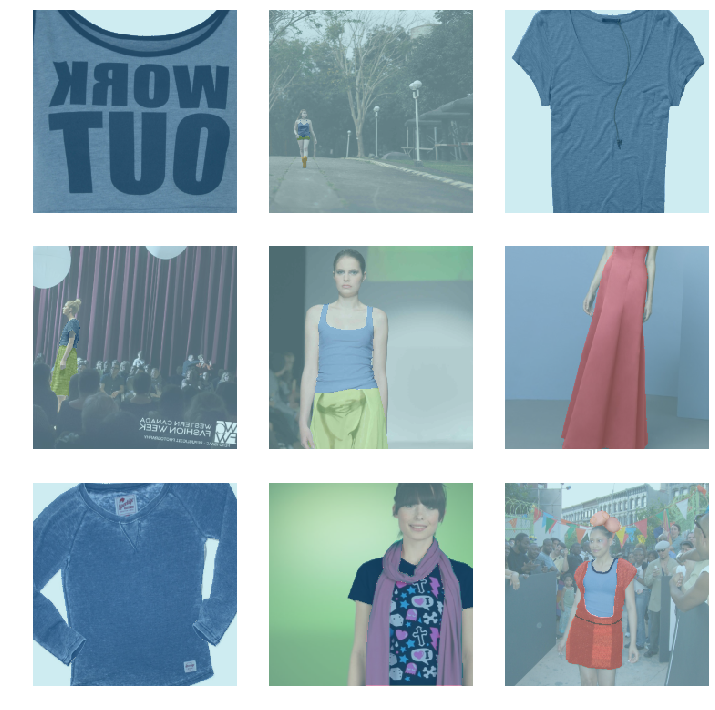

In [18]:
data.show_batch(3, figsize=(10,10))

In [19]:
def acc_fashion(input, target):
    target = target.squeeze(1)
    mask = target != category_num - 1
    return (input.argmax(dim=1)==target).float().mean()

In [20]:
learn = unet_learner(data, models.resnet34, metrics=acc_fashion, wd=wd, model_dir="/kaggle/working/models")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 93.5MB/s]


In [21]:
lr=1e-4

In [22]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_fashion,time
0,1.340904,0.890808,0.770450,19:18
1,0.773677,0.674850,0.816168,20:25
2,0.617464,0.557111,0.841400,20:33


In [24]:
learn.fit_one_cycle(2, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_fashion,time
0,0.549226,0.544727,0.840435,21:21
1,0.547537,0.503223,0.852183,21:21


In [26]:
learn.fit_one_cycle(2, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_fashion,time
0,0.490403,0.528772,0.844564,20:37
1,0.493458,0.472594,0.858471,21:26


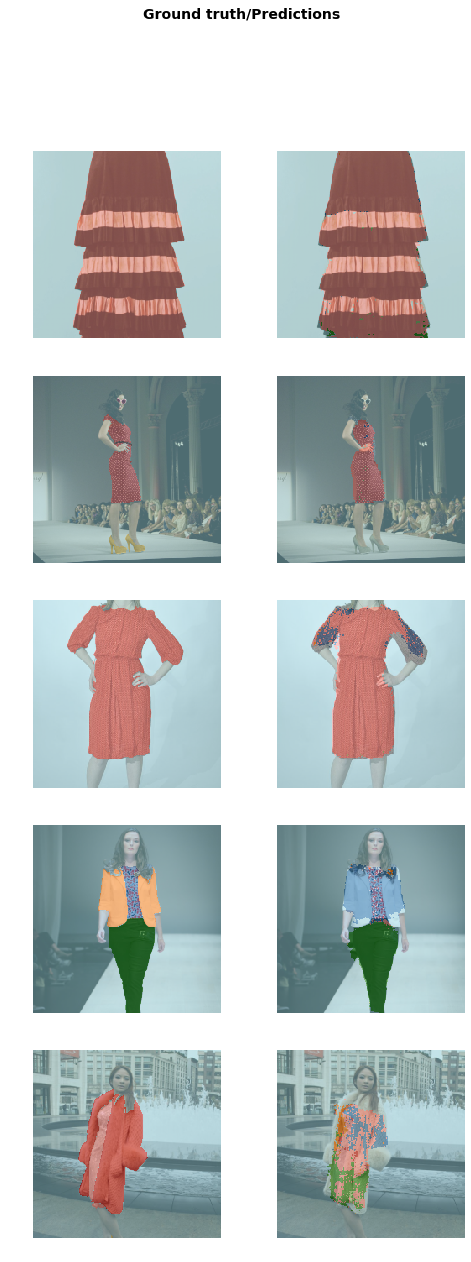

In [25]:
learn.show_results()

In [27]:
learn.unfreeze()

In [28]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(3, lrs, pct_start=0.8)

In [ ]:
learn.show_results()